# Imports

In [3]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Configs

In [303]:
INPUT_PATH = 'datasets/'
ARIMA_PATH = 'statics/arima_predict.parquet'
OUTPUT_PATH = 'results/xgb_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = ['ARIMA_predicts',
                
                'Previous_week_tip_amount',
                'Previous_2week_tip_amount',
                'Previous_day_tip_amount',

                'Previous_2week_demand',
                #'previous_2day_demand',
                'Previous_week_demand', 
                'Previous_day_demand',

                'Previous_week_extra',
                #'Previous_2week_extra',
                #'Previous_day_extra',
                
                #'Previous_2week_RatecodeID',
                'Previous_week_RatecodeID',
                #'Previous_day_RatecodeID',

                'Previous_week_congestion_surcharge',
                #'Previous_2week_congestion_surcharge',
                #'Previous_day_congestion_surcharge',

                #'Day_of_month', 
                #'Day_of_week'
                ]

TEST_START_DATE = '2023-04-1'

AUTO_TUNE = False

# Data preparation


## Load Data

In [284]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID', 'trip_distance', 'total_amount', 'passenger_count', 'fare_amount', 'extra', 
                                        'RatecodeID', 'congestion_surcharge', 'mta_tax', 'payment_type', 'tip_amount'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [285]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [286]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 13)


,tpep_pickup_datetime,PULocationID,trip_distance,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,mta_tax,payment_type,tip_amount,PU_date
0,2023-01-01 00:32:10,161,0.97,14.30,1.0,9.3,1.00,1.0,2.5,0.5,2,0.00,2023-01-01
1,2023-01-01 00:55:08,43,1.10,16.90,1.0,7.9,1.00,1.0,2.5,0.5,1,4.00,2023-01-01
2,2023-01-01 00:25:04,48,2.51,34.90,1.0,14.9,1.00,1.0,2.5,0.5,1,15.00,2023-01-01
3,2023-01-01 00:03:48,138,1.90,20.85,0.0,12.1,7.25,1.0,0.0,0.5,1,0.00,2023-01-01
4,2023-01-01 00:10:29,107,1.43,19.68,1.0,11.4,1.00,1.0,2.5,0.5,1,3.28,2023-01-01


In [26]:
statics_df = pd.read_parquet(ARIMA_PATH)

In [27]:
print(f'rides dataframe shape : {statics_df.shape}')
statics_df.head()

rides dataframe shape : (27772, 1)


,0
0,18
1,0
2,1
3,86
4,1


## Labeling

In [335]:
def labeling(dataset):
    '''dataset_labels_demand = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )'''
    dataset_labels = (
                rides_df.groupby(['PULocationID', 'PU_date'])
                .agg({'trip_distance': 'sum', 'tpep_pickup_datetime': 'count', 'total_amount': 'max', 'passenger_count': 'median' ,'fare_amount': 'max', 'extra': 'max',
                      'RatecodeID': 'max', 'congestion_surcharge': 'median', 'tip_amount': 'sum'})
                .reset_index()
                .rename(columns={'trip_distance': 'trip_dists', 'tpep_pickup_datetime': 'Demand', 'PULocationID': 'Location', 'PU_date': 'Date'})
)

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )

    return labels_df


In [336]:
labeled_df = labeling(rides_df)

In [337]:
labeled_df.corr()

C:\Users\bardia\AppData\Local\Temp\ipykernel_14744\88742821.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  labeled_df.corr()


,Location,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,tip_amount
Location,1.000000,0.062112,0.170603,0.108762,0.016235,0.101904,0.132396,0.004881,0.090494,0.116440
trip_dists,0.062112,1.000000,0.545723,0.419847,0.056160,0.412153,0.349627,-0.038136,0.272568,0.738038
Demand,0.170603,0.545723,1.000000,0.549526,0.110859,0.499474,0.699069,0.017784,0.652117,0.872268
total_amount,0.108762,0.419847,0.549526,1.000000,0.327228,0.979716,0.617278,0.165308,0.492916,0.582771
passenger_count,0.016235,0.056160,0.110859,0.327228,1.000000,0.304021,0.238119,0.383892,0.184746,0.088691
fare_amount,0.101904,0.412153,0.499474,0.979716,0.304021,1.000000,0.544366,0.163487,0.420301,0.557005
extra,0.132396,0.349627,0.699069,0.617278,0.238119,0.544366,1.000000,0.076257,0.786686,0.575552
RatecodeID,0.004881,-0.038136,0.017784,0.165308,0.383892,0.163487,0.076257,1.000000,-0.054519,-0.033141
congestion_surcharge,0.090494,0.272568,0.652117,0.492916,0.184746,0.420301,0.786686,-0.054519,1.000000,0.487463
tip_amount,0.116440,0.738038,0.872268,0.582771,0.088691,0.557005,0.575552,-0.033141,0.487463,1.000000


In [307]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 11)


,Location,Date,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,tip_amount
0,1,2023-01-01,17.71,40.0,276.00,6.0,86.040500,0.0,5.0,0.0,393.43
1,1,2023-01-02,27.54,31.0,279.50,4.0,87.085806,0.0,5.0,0.0,363.76
2,1,2023-01-03,0.40,27.0,351.00,5.0,82.731852,0.0,5.0,0.0,296.50
3,1,2023-01-04,2.60,7.0,204.69,4.0,107.390000,0.0,5.0,0.0,194.64
4,1,2023-01-05,17.50,15.0,213.00,4.0,89.377333,0.0,5.0,0.0,200.13


## Add Feature

In [308]:
def feature_engineering(dataset, statics_df):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)

    dataset['Previous_week_tip_amount'] = dataset.groupby(['Location'])['tip_amount'].shift(7)
    dataset['Previous_2week_tip_amount'] = dataset.groupby(['Location'])['tip_amount'].shift(14)
    dataset['Previous_day_tip_amount'] = dataset.groupby(['Location'])['tip_amount'].shift(1)

    dataset['Previous_week_extra'] = dataset.groupby(['Location'])['extra'].shift(7)
    dataset['Previous_2week_extra'] = dataset.groupby(['Location'])['extra'].shift(14)
    dataset['Previous_day_extra'] = dataset.groupby(['Location'])['extra'].shift(1)
    
    dataset['Previous_week_RatecodeID'] = dataset.groupby(['Location'])['RatecodeID'].shift(7)
    dataset['Previous_2week_RatecodeID'] = dataset.groupby(['Location'])['RatecodeID'].shift(14)
    dataset['Previous_day_RatecodeID'] = dataset.groupby(['Location'])['RatecodeID'].shift(1)

    dataset['Previous_week_congestion_surcharge'] = dataset.groupby(['Location'])['congestion_surcharge'].shift(7)
    dataset['Previous_2week_congestion_surcharge'] = dataset.groupby(['Location'])['congestion_surcharge'].shift(14)
    dataset['Previous_day_congestion_surcharge'] = dataset.groupby(['Location'])['congestion_surcharge'].shift(1)


    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day

    dataset = dataset.sort_values(by = ['Date', 'Location'])
    dataset['ARIMA_predicts'] = None
    start_index = len(dataset) - len(statics_df)
    end_index = len(dataset)
    dataset.iloc[start_index:end_index, dataset.columns.get_loc('ARIMA_predicts')] = statics_df
    dataset['ARIMA_predicts'] = dataset['ARIMA_predicts'].astype('float')
    dataset = dataset.sort_values(by = ['Location', 'Date'])
    
    return dataset

In [309]:
features_df = feature_engineering(labeled_df, statics_df)
features_df.dropna(inplace = True)

In [310]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 30)


,Location,Date,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,...,Previous_day_extra,Previous_week_RatecodeID,Previous_2week_RatecodeID,Previous_day_RatecodeID,Previous_week_congestion_surcharge,Previous_2week_congestion_surcharge,Previous_day_congestion_surcharge,Day_of_week,Day_of_month,ARIMA_predicts
14,1,2023-01-15,0.70,19.0,181.00,4.0,83.149474,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,6,15,18.0
15,1,2023-01-16,20.90,21.0,213.76,4.0,72.167143,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0,16,18.0
16,1,2023-01-17,20.80,18.0,145.20,3.0,71.450000,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,1,17,19.0
17,1,2023-01-18,21.00,10.0,151.20,2.0,73.275000,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,2,18,17.0
18,1,2023-01-19,0.06,9.0,158.50,3.0,91.722222,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,3,19,12.0


In [311]:
features_df.corr()

C:\Users\bardia\AppData\Local\Temp\ipykernel_14744\2297156001.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features_df.corr()


,Location,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,tip_amount,...,Previous_day_extra,Previous_week_RatecodeID,Previous_2week_RatecodeID,Previous_day_RatecodeID,Previous_week_congestion_surcharge,Previous_2week_congestion_surcharge,Previous_day_congestion_surcharge,Day_of_week,Day_of_month,ARIMA_predicts
Location,1.000000e+00,0.016560,0.170959,0.109823,0.102200,-0.042607,0.078192,-0.066434,0.091814,0.117047,...,0.078305,-0.065298,-0.063124,-0.065471,0.091391,0.090324,0.091751,-3.698266e-15,4.147200e-15,0.173911
trip_dists,1.655998e-02,1.000000,0.061732,0.043727,0.062466,-0.013945,0.035018,-0.028318,0.063318,0.047802,...,0.034080,-0.027904,-0.028057,-0.027883,0.060708,0.061374,0.060295,4.189981e-03,-4.154817e-03,0.061389
Demand,1.709591e-01,0.061732,1.000000,0.548697,0.603338,-0.126895,0.513865,-0.262799,0.657677,0.872966,...,0.510862,-0.260133,-0.258212,-0.262815,0.654072,0.650276,0.657170,4.820910e-03,-1.952406e-03,0.985595
total_amount,1.098235e-01,0.043727,0.548697,1.000000,0.624873,0.353902,0.398505,-0.170701,0.493937,0.582222,...,0.389678,-0.190639,-0.191033,-0.201045,0.487276,0.486960,0.490746,-2.320819e-03,7.704225e-03,0.548087
passenger_count,1.022003e-01,0.062466,0.603338,0.624873,1.000000,-0.000460,0.474229,-0.368130,0.751338,0.489077,...,0.460586,-0.371365,-0.367066,-0.374191,0.743285,0.741030,0.745628,1.312128e-02,-2.458479e-03,0.607510
fare_amount,-4.260710e-02,-0.013945,-0.126895,0.353902,-0.000460,1.000000,-0.044676,0.370029,-0.126969,-0.017578,...,-0.071492,0.261476,0.260666,0.249108,-0.153583,-0.153792,-0.157958,-2.766181e-02,3.574295e-03,-0.128817
extra,7.819233e-02,0.035018,0.513865,0.398505,0.474229,-0.044676,1.000000,-0.275167,0.562104,0.519119,...,0.631202,-0.246288,-0.244276,-0.241732,0.537964,0.534319,0.532607,-7.686768e-02,2.207181e-03,0.493384
RatecodeID,-6.643417e-02,-0.028318,-0.262799,-0.170701,-0.368130,0.370029,-0.275167,1.000000,-0.377470,-0.212180,...,-0.244582,0.623321,0.631924,0.582989,-0.369180,-0.369703,-0.369295,-1.294269e-01,8.321663e-04,-0.265091
congestion_surcharge,9.181351e-02,0.063318,0.657677,0.493937,0.751338,-0.126969,0.562104,-0.377470,1.000000,0.495171,...,0.533741,-0.365151,-0.362727,-0.365564,0.885407,0.879892,0.885869,7.729054e-03,2.546995e-03,0.661591
tip_amount,1.170473e-01,0.047802,0.872966,0.582222,0.489077,-0.017578,0.519119,-0.212180,0.495171,1.000000,...,0.510986,-0.209796,-0.208227,-0.211858,0.489513,0.483815,0.494213,9.485269e-06,1.815178e-03,0.855310


In [312]:
pca = PCA()
pca.fit(features_df[FEATURE_LIST])


cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum, len(FEATURE_LIST), pca.feature_names_in_

(array([0.96820216, 0.98325203, 0.99603354, 0.9996278 , 0.99982006,
        0.99992767, 0.99997096, 0.99999999, 1.        , 1.        ]),
 10,
 array(['ARIMA_predicts', 'Previous_week_tip_amount',
        'Previous_2week_tip_amount', 'Previous_day_tip_amount',
        'Previous_2week_demand', 'Previous_week_demand',
        'Previous_day_demand', 'Previous_week_extra',
        'Previous_week_RatecodeID', 'Previous_week_congestion_surcharge'],
       dtype=object))

## Split Train and Test Data

In [313]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [314]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [315]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (19912, 30)


,Location,Date,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,...,Previous_day_extra,Previous_week_RatecodeID,Previous_2week_RatecodeID,Previous_day_RatecodeID,Previous_week_congestion_surcharge,Previous_2week_congestion_surcharge,Previous_day_congestion_surcharge,Day_of_week,Day_of_month,ARIMA_predicts
14,1,2023-01-15,0.70,19.0,181.00,4.0,83.149474,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,6,15,18.0
15,1,2023-01-16,20.90,21.0,213.76,4.0,72.167143,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0,16,18.0
16,1,2023-01-17,20.80,18.0,145.20,3.0,71.450000,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,1,17,19.0
17,1,2023-01-18,21.00,10.0,151.20,2.0,73.275000,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,2,18,17.0
18,1,2023-01-19,0.06,9.0,158.50,3.0,91.722222,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,3,19,12.0


In [316]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 30)


,Location,Date,trip_dists,Demand,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,...,Previous_day_extra,Previous_week_RatecodeID,Previous_2week_RatecodeID,Previous_day_RatecodeID,Previous_week_congestion_surcharge,Previous_2week_congestion_surcharge,Previous_day_congestion_surcharge,Day_of_week,Day_of_month,ARIMA_predicts
90,1,2023-04-01,0.02,13.0,194.10,4.0,78.119231,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,5,1,13.0
91,1,2023-04-02,1.83,17.0,156.55,4.0,91.463529,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,6,2,13.0
92,1,2023-04-03,18.13,9.0,154.00,3.0,67.388889,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0,3,15.0
93,1,2023-04-04,0.01,12.0,145.00,4.0,103.383333,0.0,5.0,0.0,...,0.0,5.0,5.0,5.0,0.0,0.0,0.0,1,4,11.0
94,1,2023-04-05,0.58,18.0,157.20,4.0,87.236667,0.0,5.0,0.0,...,0.0,5.0,3.0,5.0,0.0,0.0,0.0,2,5,13.0


# Model Training

## **Ridge Regression**

### Model Tuning

In [317]:
def grid_search(model, test_parameters, train_data, cv = None, feature_list = FEATURE_LIST):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [318]:
model = Ridge()
best_params, best_score = grid_search(
    model, 
    {'alpha':[0, 1, 10, 100, 1000]},
    train_df, 
    cv = 5, 
    feature_list = FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 0} -95.01082778269145


### Prediction

In [319]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])


    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [320]:
model = Ridge(**best_params)
train_prediction_df , test_prediction_df  = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [321]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [322]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):


    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

C:\Users\bardia\AppData\Local\Temp\ipykernel_14744\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_14744\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_14744\2246591508.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

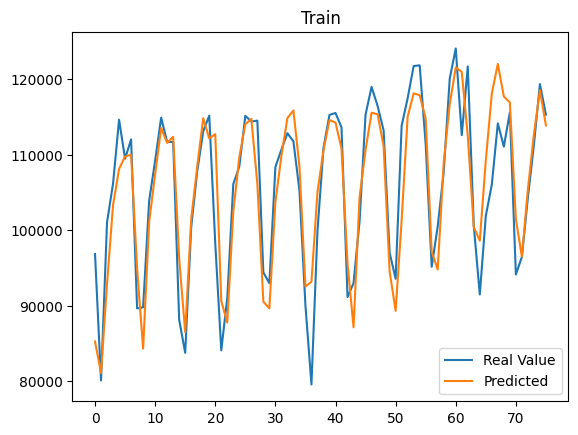

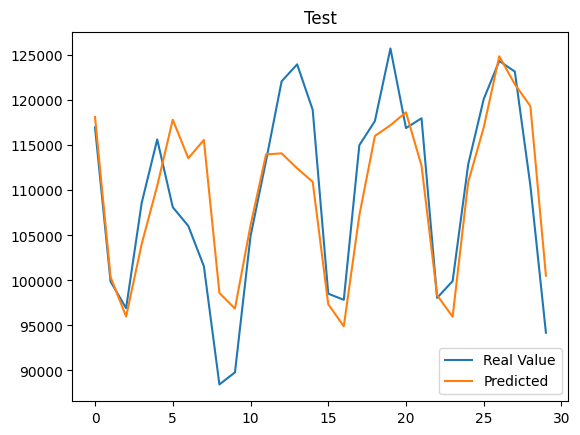

In [323]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [324]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [325]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['Demand'], test_prediction_df)


In [326]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 31.134536516968033
MSE : 10168.368888800354
MAPE : 1081836063274080.9
Ridge Regression test scores:
MAE : 33.144661333140576
MSE : 10097.745406254022
MAPE : 1164674416311480.0


# File Saving

In [327]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [328]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [329]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)

C:\Users\bardia\AppData\Local\Temp\ipykernel_14744\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


In [330]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,16.370947
1,1,2023-04-02,18.906560
2,1,2023-04-03,8.478683
3,1,2023-04-04,11.162216
4,1,2023-04-05,8.794914


In [331]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)